# Simulate long-range migration edge 

As an initial attempt, I will just add a **single** long range migration edge to a specific internal node **on top** of the original triangular lattice from before. I can envision using a greedy approach to fitting this likelihood function by adding a penalty term for which two nodes gets this edge...

Here, I will test the output of the function as I am developing it (code adapted from `sandbox.ipynb`)

## Changes to original code base:
1. adding function `setup_graph_long_range` in `sim.py`

## Imports

In [12]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.cross_validation import comp_mats, run_cv
from feems.helper_funcs import plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Testing function + visualization
*Note: nodes are numbered left-right, bottom-top by default in `networkx`*

In [5]:
lrn = [(0,12)]
## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=[(0,12)], long_range_edges=[2.0])

In [6]:
gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 900
Simulating ~SNP 950


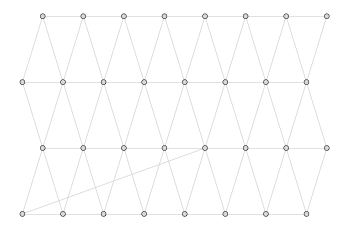

In [8]:
# repeating the same process as above but fitting the data on a graph with NO long range edges
graph_def, _, _, edge_def = setup_graph(n_rows=4, n_columns=8, barrier_startpt=2.5, barrier_endpt=5.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

# plotting skeleton of the graph
proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
fig = plt.figure()
# drawing the simulated graph 
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

## Default `feems` fit  

In [318]:
%%time
#sp_Graph.fit_null_model()
#sp_Graph.fit(lamb = 10.0)

constant-w/variance fit, converged in 123 iterations, train_loss=3479.1321937
CPU times: user 956 ms, sys: 24.5 ms, total: 981 ms
Wall time: 291 ms


Surprisingly, it seems like the long range migration edge (0,12) is captured by the model! However, this could be because I set the long range migraton to be 4x more than corridor and 20x more than barrier migration rate. Below I use a root mean squared relative error to calculate deviation of estimated from simulated but weighted with respect to the estimated value
$$
\text{RMSRE} = \sqrt{1/n \sum_i \Big(\frac{X_i - T_i}{T_i}\Big)^2}
$$

In [41]:
def rmsre_edge_weights(graph, sp_Graph):
    # simulated graph edges
    sim_edges = np.array([graph[val[0]][val[1]]["w"] for _, val in enumerate(list(graph.edges))])
    return np.sqrt(np.mean(((sp_Graph.w-sim_edges)/sp_Graph.w)**2))

constant-w/variance fit, converged in 125 iterations, train_loss=3555.3221813
lambda=10.0000000, alpha=0.6127014, converged in 12 iterations, train_loss=3409.8507312
constant-w/variance fit, converged in 121 iterations, train_loss=3410.4765504
lambda=10.0000000, alpha=0.7021825, converged in 13 iterations, train_loss=3270.5959686
constant-w/variance fit, converged in 121 iterations, train_loss=3410.4765504
lambda=10.0000000, alpha=0.7021825, converged in 12 iterations, train_loss=3270.5959688


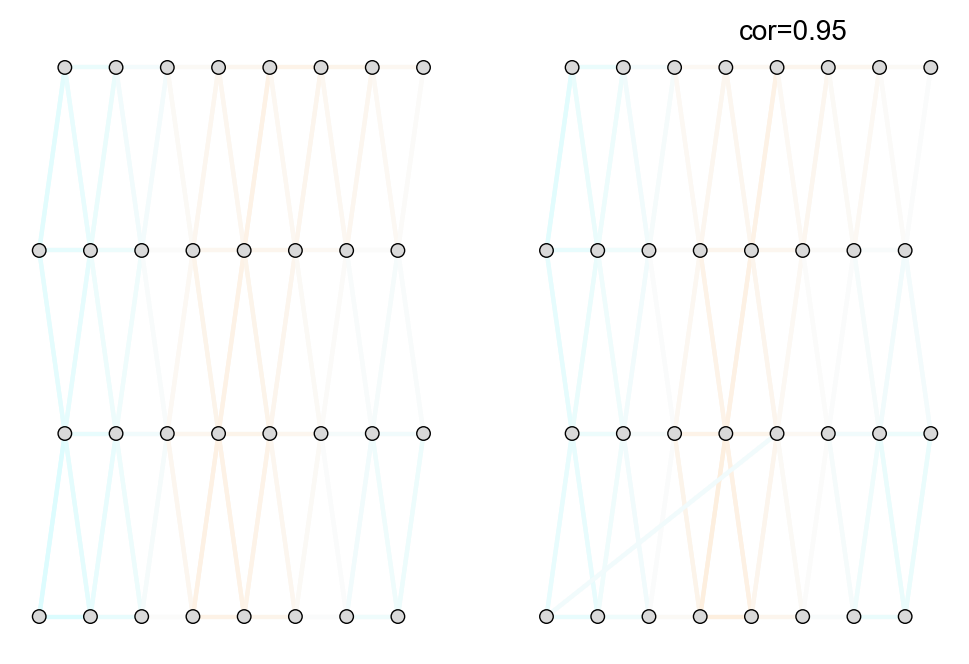

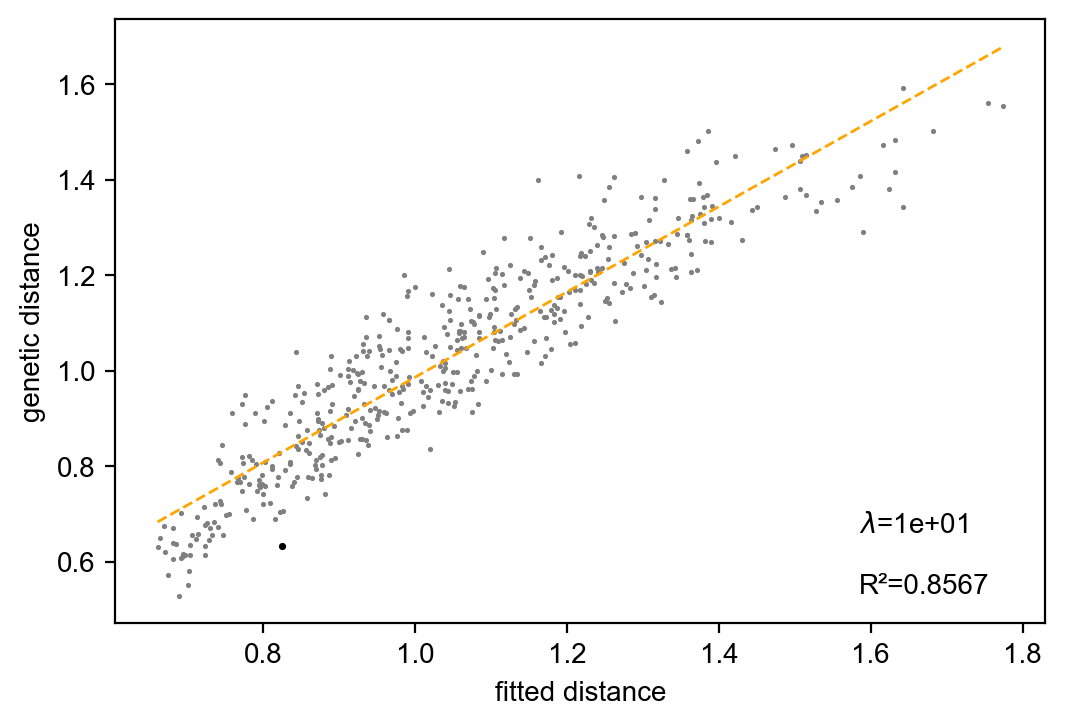

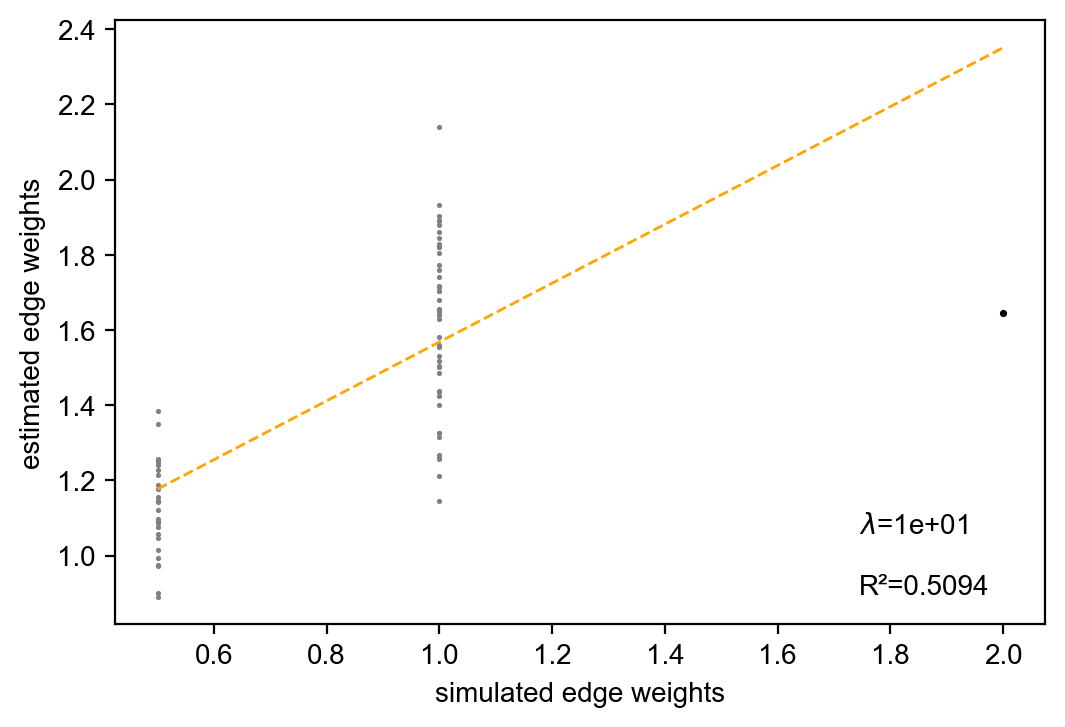

In [13]:
# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, lrn, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, lamb=10.0)

### Further testing with varying parameters 

Now, I will try out the following parameter regimes: more disconnected long range edges, weaker long range migration, and multiple incoming long range edges to same node. The previous parameter regime had one long range edge between node 0 and 12 with migration rate of 1.0 (compared to 0.5 in the corridors and 0.1 in the barrier). 

#### 1. Varying number of long range edges

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


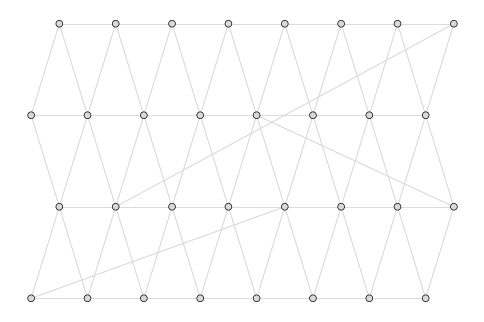

In [14]:
lrn = [(0,12),(15,20),(9,31)]
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [6]:
# %%time
# sp_Graph.fit(lamb = 1.0)

constant-w/variance fit, converged in 128 iterations, train_loss=13100.7453796
lambda=1.0000000, alpha=1.3216153, converged in 15 iterations, train_loss=11717.7593576
CPU times: user 1.17 s, sys: 27.5 ms, total: 1.19 s
Wall time: 385 ms


constant-w/variance fit, converged in 125 iterations, train_loss=3555.3221813
lambda=10.0000000, alpha=0.6127014, converged in 12 iterations, train_loss=3409.8507312
constant-w/variance fit, converged in 126 iterations, train_loss=12743.6631067
lambda=10.0000000, alpha=1.3218379, converged in 12 iterations, train_loss=11928.4653569
constant-w/variance fit, converged in 126 iterations, train_loss=12743.6631067
lambda=10.0000000, alpha=1.3218379, converged in 13 iterations, train_loss=11928.4653561


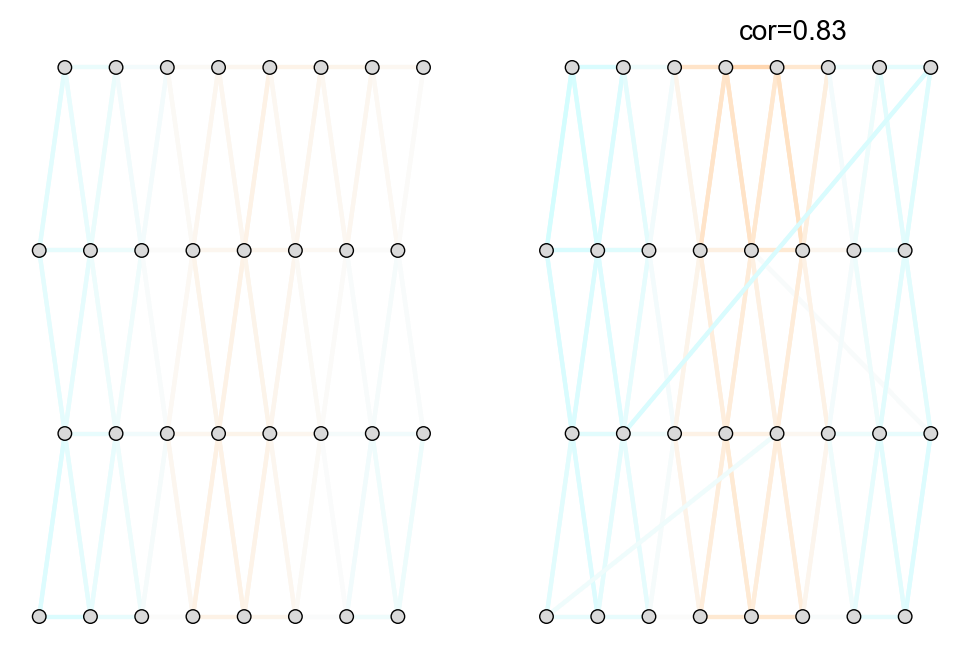

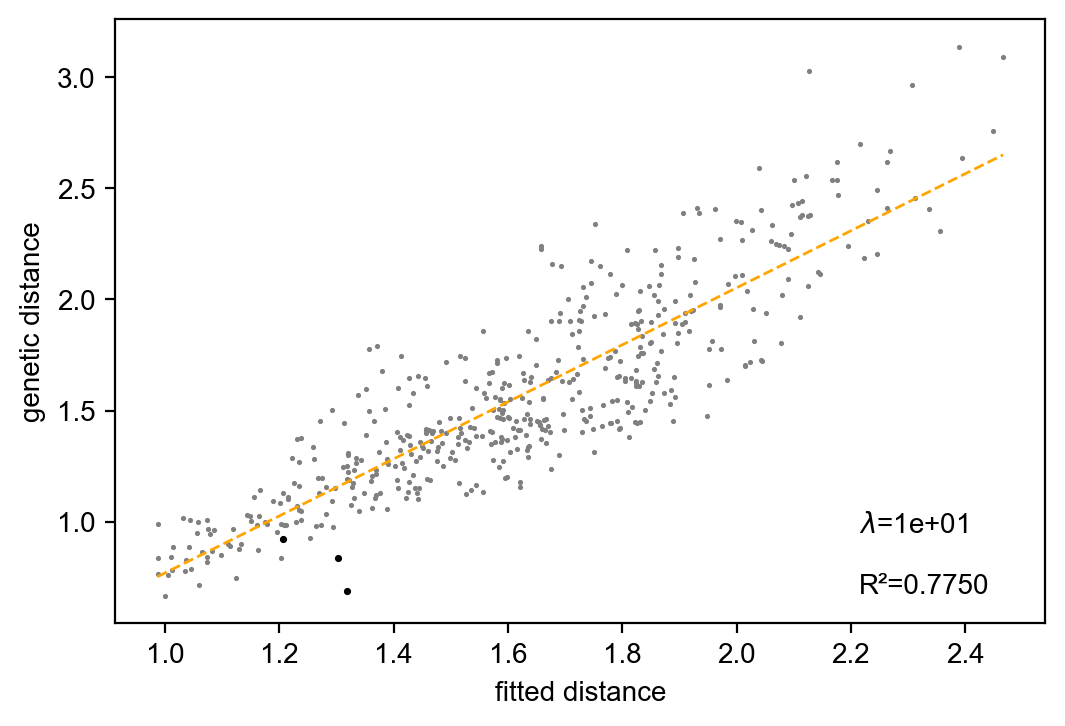

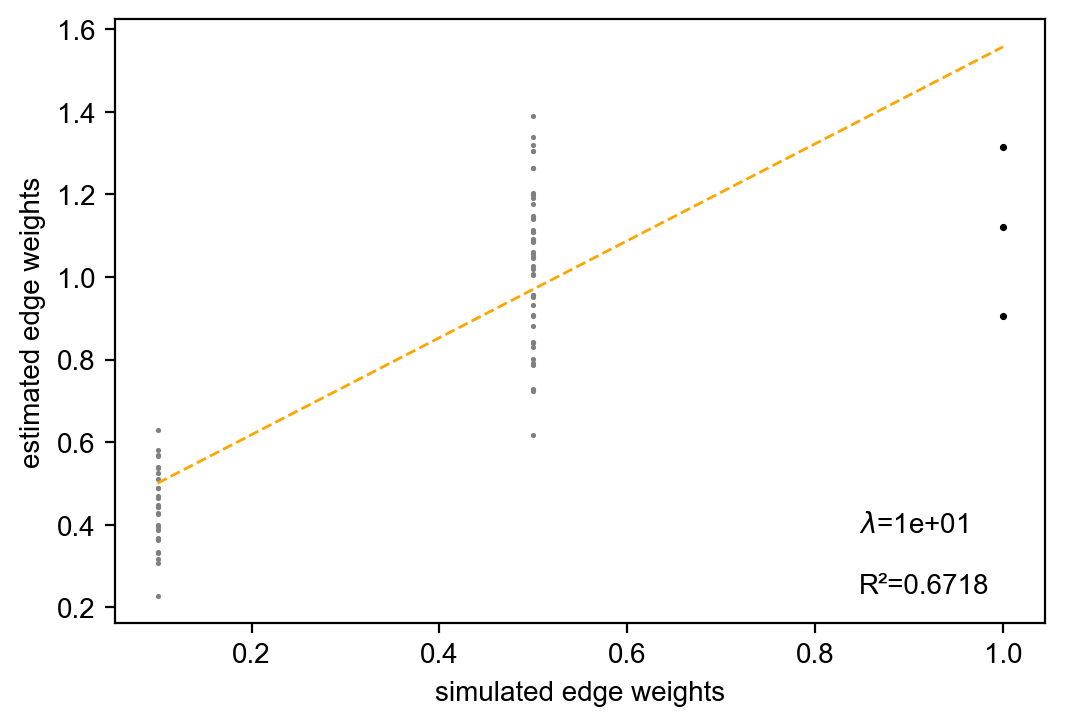

In [15]:
# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, lrn, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, lamb=10.0)

The above result shows that `feems` does pretty well in finding multiple long range migration edges, even with somewhat similar migration rates to the corridors (2x, compared to 4x from before). 

#### 2. Weak migration (similar to corridor rates)

Based on the results from the analysis below, I still find that `feems` does well in capturing these long range migrations. 

Simulating ~SNP 50
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 350
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850


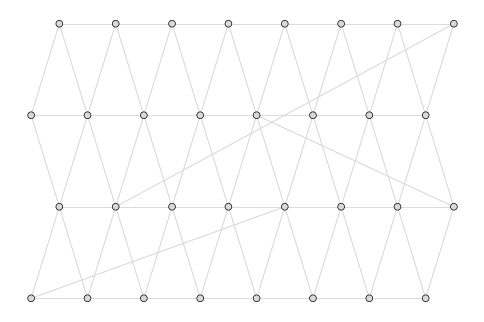

In [16]:
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[0.5,0.5,0.5])
gen_test = simulate_genotypes(graph)
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

constant-w/variance fit, converged in 125 iterations, train_loss=3555.3221813
lambda=10.0000000, alpha=0.6127014, converged in 12 iterations, train_loss=3409.8507312
constant-w/variance fit, converged in 129 iterations, train_loss=14310.0654619
lambda=10.0000000, alpha=1.3451810, converged in 12 iterations, train_loss=13417.1987233
constant-w/variance fit, converged in 129 iterations, train_loss=14310.0654619
lambda=10.0000000, alpha=1.3451810, converged in 13 iterations, train_loss=13417.1987158


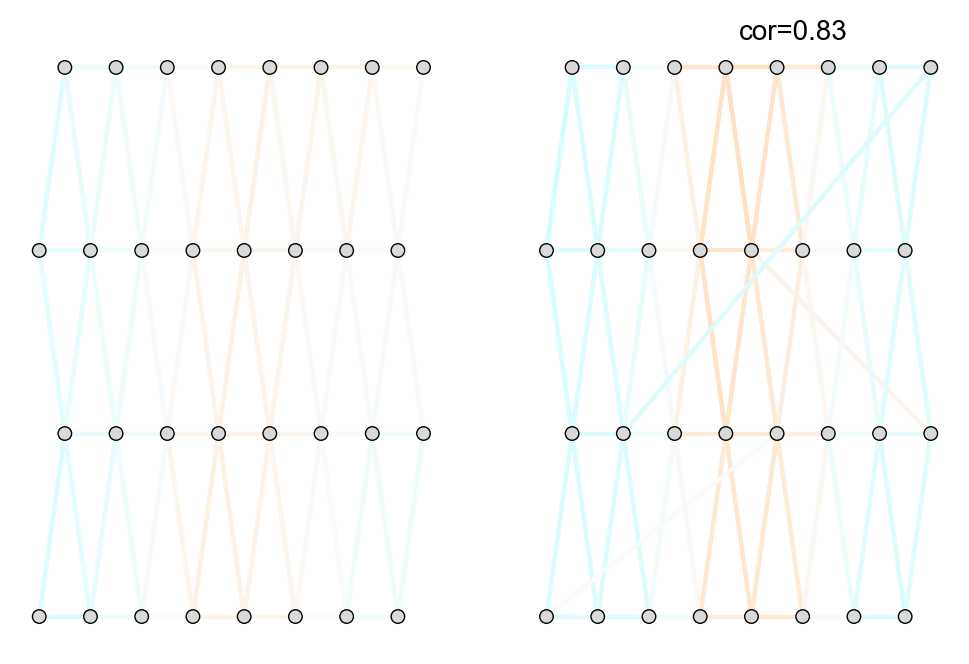

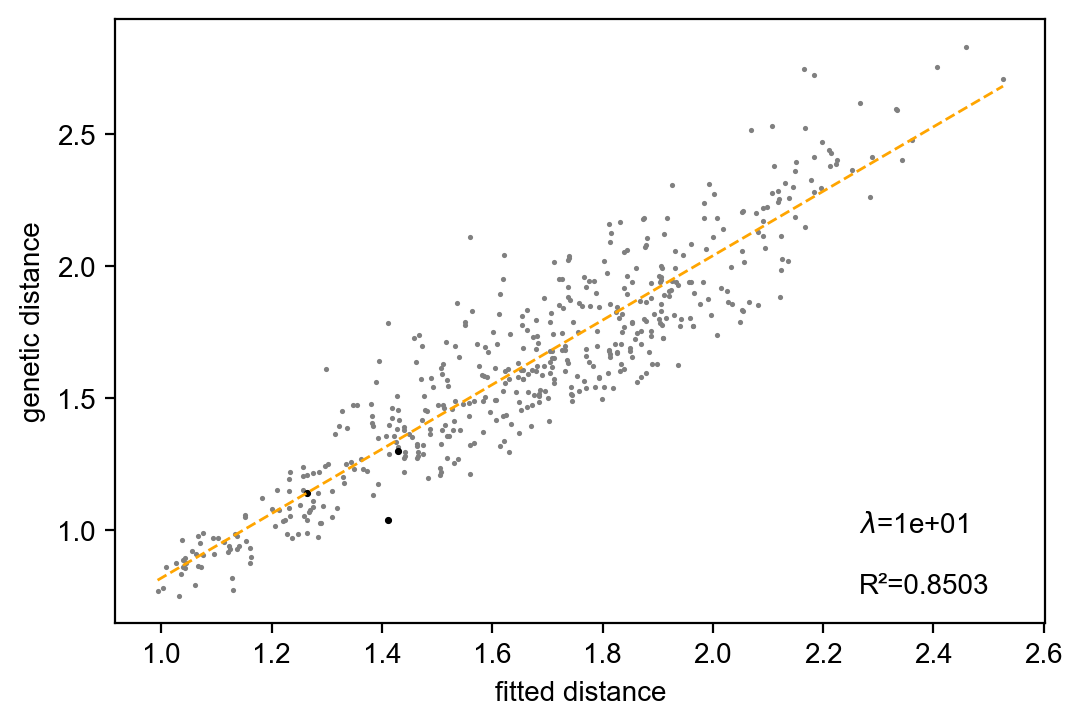

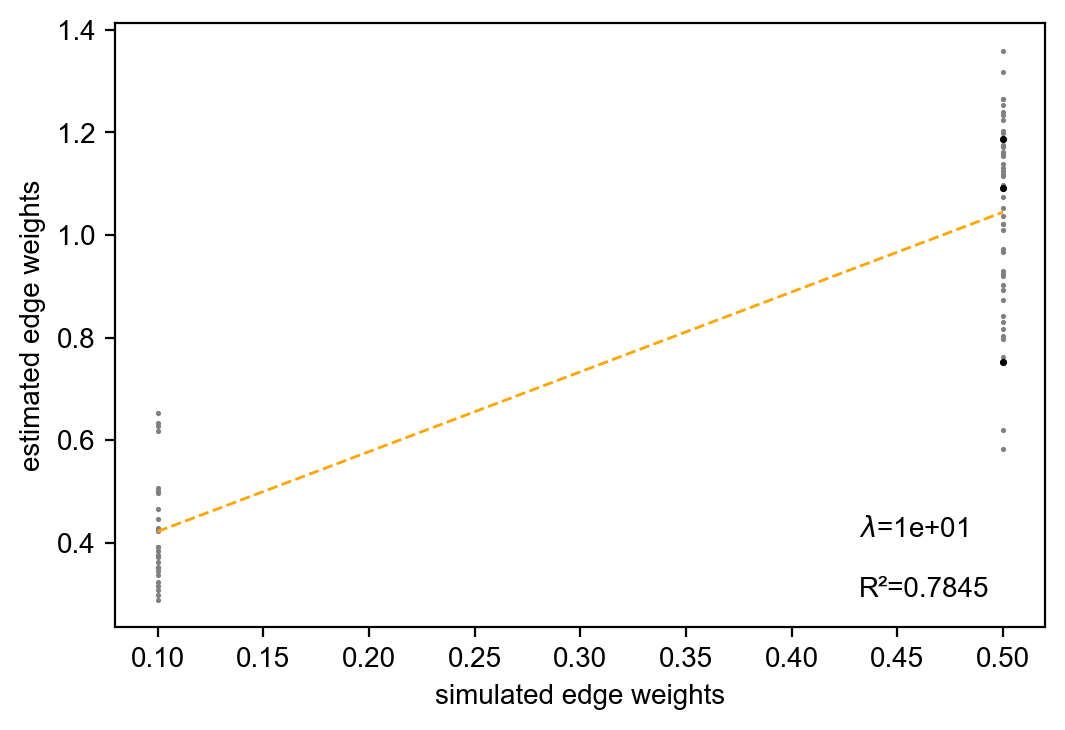

In [17]:
# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, lrn, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, lamb=10.0)

#### 3. Multiple long range migration edges to same node

Based on the results below, `feems` works well to estimate these long range migration edges accurately, even with multiple edges to the same node. 

Simulating ~SNP 100
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 500
Simulating ~SNP 600
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 900
Simulating ~SNP 950


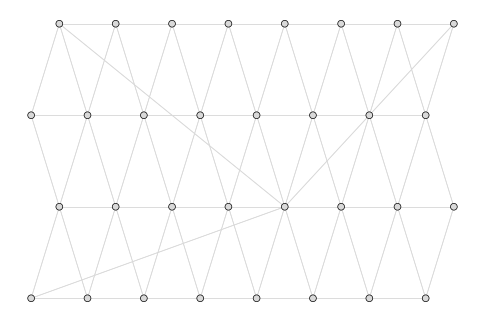

In [18]:
lrn = [(0,12),(12,31),(12,24)]
graph, coord, grid, edge = setup_graph_long_range(corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.0,1.0,1.0])
gen_test = simulate_genotypes(graph)
# constructing the graph object
sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

constant-w/variance fit, converged in 125 iterations, train_loss=3555.3221813
lambda=10.0000000, alpha=0.6127014, converged in 12 iterations, train_loss=3409.8507312
constant-w/variance fit, converged in 129 iterations, train_loss=13344.3940475
lambda=10.0000000, alpha=1.3856953, converged in 12 iterations, train_loss=12457.6893324
constant-w/variance fit, converged in 129 iterations, train_loss=13344.3940475
lambda=10.0000000, alpha=1.3856953, converged in 13 iterations, train_loss=12457.6893314


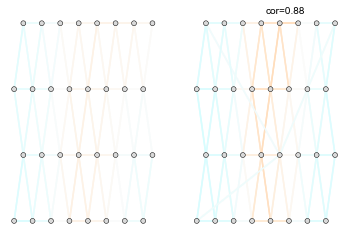

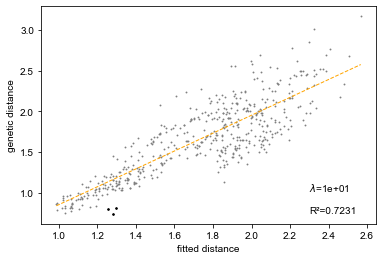

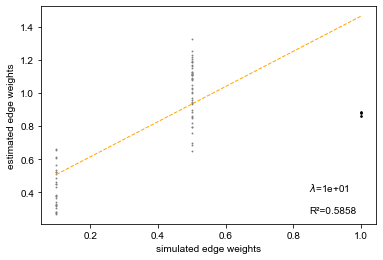

In [19]:
# visualtization of feems fit
plot_default_vs_long_range(sp_Graph_def, sp_Graph, lrn, lamb=10.0)

comp_genetic_vs_fitted_distance(sp_Graph, lrn, lamb=10.0, plotFig=True)

plot_estimated_vs_simulated_edges(graph, sp_Graph, lrn, lamb=10.0)

### Spoofing the model by giving it all possible edges

Here, I will simulate under the model in **3** (multiple long range edges to same node) above, but will provide the model with edges connecting every population to every other population as a way of seeing if the model can detect the edges with long range migration. 

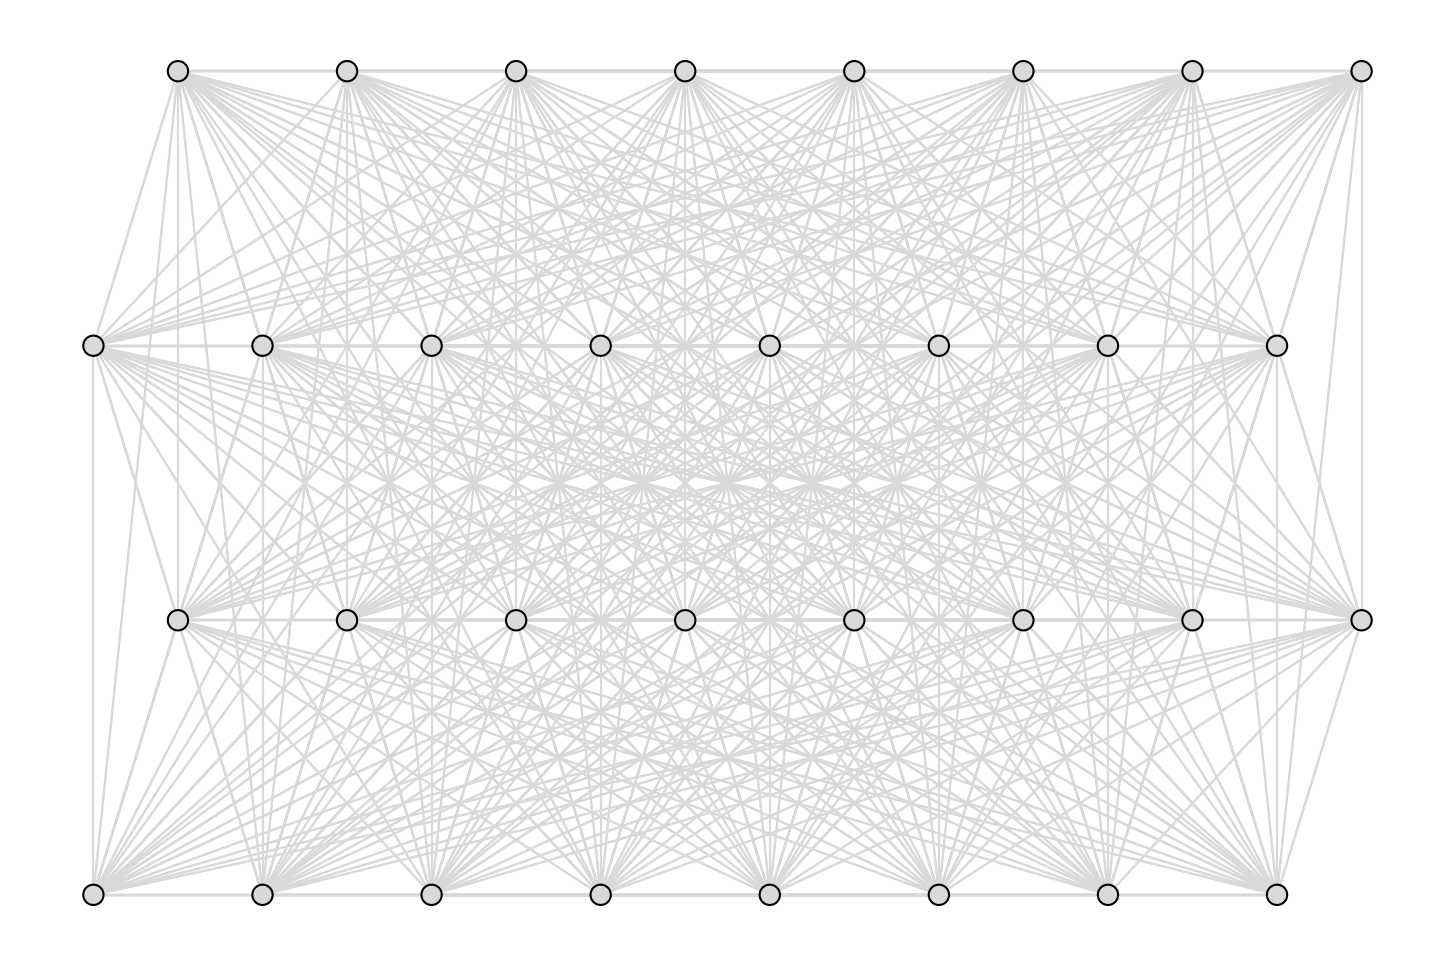

In [9]:
# constructing the graph object
## every combination of edge with same genotypes as before
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(list(it.combinations(np.arange(1,33),2))))

proj_test = ccrs.EquidistantConic(central_longitude=5.5, central_latitude=3.0)
# drawing the simulated graph 
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_samples()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False)

In [17]:
%%time
sp_Graph.fit(lamb = 0.1)

constant-w/variance fit, converged in 85 iterations, train_loss=16078.8566203
lambda=0.1000000, alpha=7.9050177, converged in 10 iterations, train_loss=15764.0032374
CPU times: user 876 ms, sys: 33.6 ms, total: 910 ms
Wall time: 323 ms


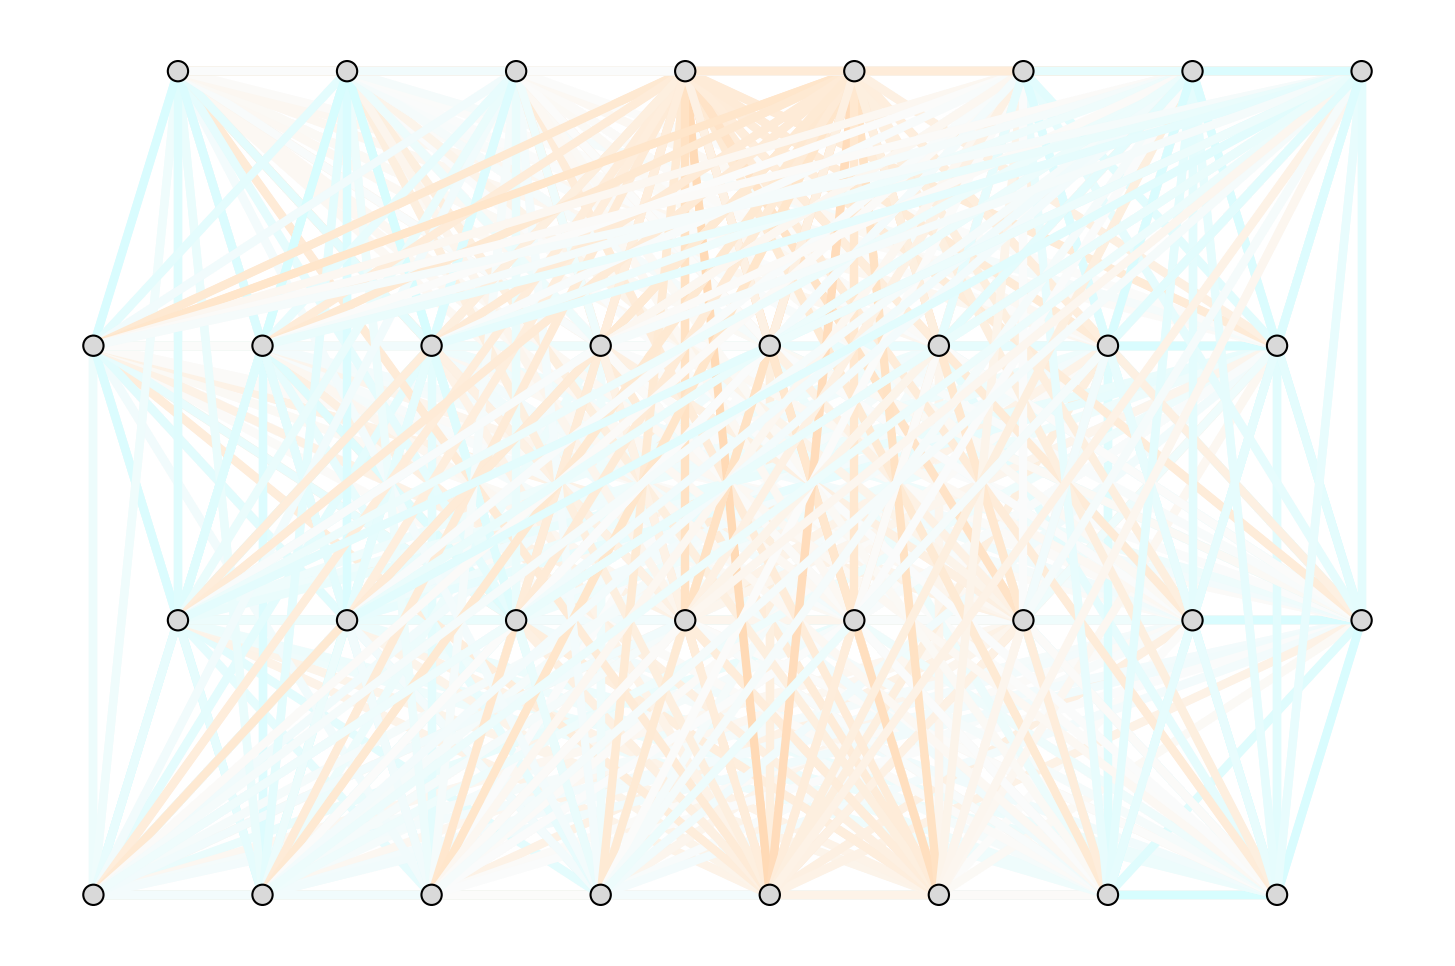

In [18]:
fig = plt.figure(dpi=100)
# plotting feems result
ax = fig.add_subplot(1, 1, 1)  
v = Viz(ax, sp_Graph, edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 

## Investigating the 'greedy' approach to fitting long range edges

First, I will see if the covariance of allele frequencies across nodes tells us something about which nodes could potentially have a long range migration. This seems promising, in that for node 0 is found to covary with node 12 the third-most (right after its neighboring nodes). 

In [222]:
np.set_printoptions(threshold=np.inf)
np.argsort(sp_Graph.S[16,:],)
#sp_Graph.S[12,:]-np.max(sp_Graph.S[12,:])

array([30, 31,  5, 21,  6, 15, 23,  7, 29, 22, 13, 14, 28, 27,  4, 12, 20,
       11,  0,  3,  2,  9, 19, 26, 10, 24, 18,  1, 17,  8, 25, 16])